In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from dataclasses import dataclass, field
from abc import ABC, abstractmethod
from enum import Enum, auto
from collections.abc import Iterable
from typing import Mapping, Any, Sequence

import matplotlib.pyplot as plt

from numpy.typing import NDArray

In [26]:
class Instrument(Enum):
    STOCK = auto()
    CALL = auto()
    PUT = auto()


class Side(Enum):
    LONG = auto()
    SHORT = auto()

    @property
    def sign(self) -> int:
        return 1 if Side.LONG else -1

In [33]:
ArrayF = NDArray[np.float64]

In [39]:
@dataclass(frozen=True)
class Leg(ABC):
    side: Side
    quantity: int

    @abstractmethod
    def pnl(self, S: float) -> float:
        ...


@dataclass(frozen=True)
class CallLeg(Leg):
    strike_price: float
    premium: float

    def pnl(self, S: ArrayF) -> ArrayF:
        payoff = np.copy(S)
        payoff = self.side.sign * self.quantity * (payoff - self.strike_price)
        return np.where(payoff > 0, payoff, 0)


@dataclass(frozen=True)
class PutLeg(Leg):
    strike_price: float
    premium: float

    def pnl(self, S: ArrayF) -> ArrayF:
        payoff = np.copy(S)
        payoff = self.side.sign * self.quantity * (self.strike_price - payoff)
        return np.where(payoff > 0, payoff, 0)


@dataclass(frozen=True)
class StockLeg(Leg):
    initial_price: float

    def pnl(self, S: ArrayF) -> ArrayF:
        return self.side.sign * self.quantity * (S - self.initial_price)

In [48]:
def leg_from_dict(d: Mapping[str, Any]) -> Leg:
    try:
        t = d["Type"]
        side = d["Side"]
        qty = int(d["Quantity"])
    except KeyError as e:
        raise ValueError(f"Missing required key: {e.args[0]}") from None

    if t == Instrument.STOCK:
        if "Initial_price" not in d:
            raise ValueError("STOCK requires Initial_price")
        return StockLeg(side=side,
                        quantity=qty,
                        initial_price=float(d["Initial_price"]))

    if t == Instrument.CALL:
        if "Strike_price" not in d:
            raise ValueError("CALL requires Strike_price")
        return CallLeg(side=side,
                       quantity=qty,
                       strike_price=float(d["Strike_price"]),
                       premium=float(d.get("Premium", 0.0)))

    if t == Instrument.PUT:
        if "Strike_price" not in d:
            raise ValueError("PUT requires Strike_price")
        return PutLeg(side=side,
                      quantity=qty,
                      strike_price=float(d["Strike_price"]),
                      premium=float(d.get("Premium", 0.0)))

    raise ValueError(f"Unknown Type: {t!r}")

In [49]:
@dataclass
class Position():
    legs: tuple[Leg, ...]

    @classmethod
    def from_spec(cls, specs: Iterable[Mapping[str, Any]]):
        return cls(legs=tuple(leg_from_dict(s) for s in specs))

    def pnl_range(self, start: float, stop: float, num_prices: int) -> float:
        asset_prices = np.linspace(start, stop, num=num_prices)
        asset_pnl = sum(leg.pnl(asset_prices) for leg in self.legs)
        return np.vstack((asset_prices, asset_pnl))

In [60]:
def graph_pnl(pnl: Sequence[float]):
    fig, ax = plt.subplots()
    ax.plot(pnl[0], pnl[1])
    ax.hlines(0, pnl[0][0], pnl[0][-1], colors="k")
    ax.xlabel("Underlying Asset Price")
    ax.ylabel("P/L")
    plt.show()

In [51]:
specs = [
    {
        "Type": Instrument.STOCK,
        "Initial_price": 100,
        "Side": Side.LONG,
        "Quantity": 1,
    },
    {
        "Type": Instrument.CALL,
        "Strike_price": 110,
        "Premium": 5,
        "Side": Side.SHORT,
        "Quantity": 1,
    },
    {
        "Type": Instrument.PUT,
        "Strike_price": 90,
        "Premium": 4,
        "Side": Side.LONG,
        "Quantity": 1,
    },
]

pos = Position.from_spec(specs)

print("Position legs:")
for leg in pos.legs:
    print(" ", leg)

Position legs:
  StockLeg(side=<Side.LONG: 1>, quantity=1, initial_price=100.0)
  CallLeg(side=<Side.SHORT: 2>, quantity=1, strike_price=110.0, premium=5.0)
  PutLeg(side=<Side.LONG: 1>, quantity=1, strike_price=90.0, premium=4.0)


In [52]:
start, stop, n = 50, 150, 101
pnl = pos.pnl_range(start, stop, n)

print("PNL shape:", pnl.shape)
print("First 5 values:", pnl[:5])
print("Last 5 values:", pnl[-5:])


PNL shape: (2, 101)
First 5 values: [[ 50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.
   64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.
   78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.
   92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.
  106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.
  120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133.
  134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147.
  148. 149. 150.]
 [-10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
  -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
  -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.  -9.
   -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.
    6.   7.   8.   9.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.
   30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.
   58.  60

AttributeError: 'Axes' object has no attribute 'xlabel'

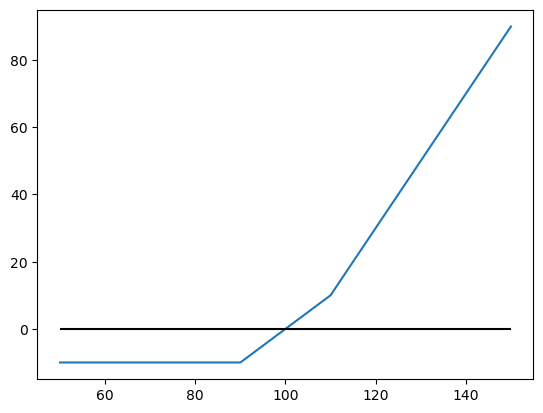

In [61]:
graph_pnl(pnl)